In [170]:
import torch, os, random, argparse
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torch.optim import SGD, Adam


torch.manual_seed(777)

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class RbfNet(nn.Module):
    def __init__(self, centers, num_class=10):
        super(RbfNet, self).__init__()
        self.num_class = num_class
        self.num_centers = centers.size(0)

        self.centers = nn.Parameter(centers)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers)/10)
        self.linear = nn.Linear(self.num_centers, self.num_class, bias=True)
        initialize_weights(self)

    def kernel_fun(self, batches):
        n_input = batches.size(0) # number of inputs
        A = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)
        B = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1)
        beta = torch.clamp(self.beta, -40, 40)
        C = torch.exp(-beta.mul((A-B).pow(2).sum(2,keepdim=False) ) )
#         C = torch.exp(-beta.mul((A-B).abs().sum(2,keepdim=False) ) )

        return C

    def forward(self, batches):
        radial_val = self.kernel_fun(batches)
        class_score = self.linear(radial_val)
        return class_score


In [171]:
model.centers

Parameter containing:
tensor([[-1.6323],
        [ 1.3164],
        [ 2.0681]], requires_grad=True)

In [172]:
model.beta

Parameter containing:
tensor([[0.9157, 1.6350, 1.3292]], requires_grad=True)

In [204]:
centers = torch.rand(20,1)
model = RbfNet(centers, num_class=1)

In [205]:
x_data = torch.linspace(-3,3).unsqueeze(1)
y_data = torch.abs(torch.sin(x_data))

In [206]:
optimizer = Adam(model.parameters(), lr=3e-2)

In [207]:
import matplotlib.pyplot as plt

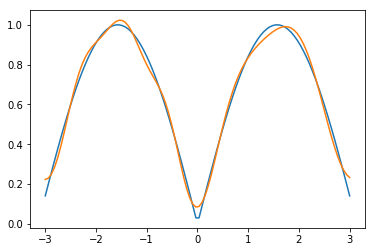

In [217]:
plt.plot(x_data.data.numpy(), y_data.data.numpy())
plt.plot(x_data.data.numpy(), y_pred.data.numpy())


In [216]:
for _ in range(100):
    
    y_pred = model(x_data)
    loss = torch.mean(torch.pow(y_data - y_pred, 2))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(loss.item())

0.0010383074404671788
0.001035272260196507
0.0010322462767362595
0.0010292320512235165
0.0010262298164889216
0.0010232352651655674
0.0010202544508501887
0.0010172822512686253
0.001014320063404739
0.0010113677708432078
0.0010084251407533884
0.0010054914746433496
0.0010025670053437352
0.000999651849269867
0.000996745890006423
0.0009938478469848633
0.0009909601649269462
0.000988078536465764
0.0009852066868916154
0.00098234333563596
0.0009794865036383271
0.0009766381699591875
0.0009737967629916966
0.0009709644946269691
0.000968139385804534
0.0009653195738792419
0.0009625069797039032
0.0009597036405466497
0.0009569059475325048
0.0009541150648146868
0.0009513337863609195
0.0009485594928264618
0.0009457974229007959
0.0009430487407371402
0.0009403260773979127
0.0009376470115967095
0.0009350497857667506
0.0009326175786554813
0.0009305240819230676
0.0009291462483815849
0.0009293002658523619
0.0009327959851361811
0.0009436143445782363
0.0009708681027404964
0.0010346205672249198
0.0011821920052170

In [210]:
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.nn.functional as F
from torch.distributions import Normal

import numpy as np

def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

class MDNModel(nn.Module):
    def __init__(self, num_features, num_inputs, num_outputs, default_layers=[128], scale=0.):
        super(MDNModel, self).__init__()

        self.num_features   = num_features
        self.num_inputs     = num_inputs
        self.num_outputs    = num_outputs

        self.mu         = nn.Linear(num_inputs, num_outputs * num_features, bias=False)

        self.pi         = nn.Sequential(
                            nn.Linear(num_inputs, default_layers[0]),
                            nn.Softplus(),
                            nn.Linear(default_layers[0], num_features)
                        )

    def forward(self, s, predict=False):

        # TODO: get rid of this later
        # _input = torch.cat([s, a], axis=1)
        _input = s
        pi = F.softmax(self.pi(_input), 1)

#         if predict is True:
#             k = gumbel_sample(pi.data.numpy())
#             idx = (np.arange(k.shape[0]), k)
#             mu  = self.mu(_input).view(-1, self.num_features, self.num_outputs)
#             return mu[idx]

        mu  = self.mu(_input)
        mu  = mu.view(-1, self.num_features, self.num_outputs)
        return pi, mu


In [2]:
import torch
import torch.nn as nn
import numpy as np

from torch.optim import SGD, Adam

import roboschool
import gym

In [3]:
from vdp_env import VDP
# from mdn_model import MDNModel

In [4]:
# env = gym.make('LunarLanderContinuous-v2')#
# env = gym.make('HalfCheetah-v2')#
# env = gym.make('RoboschoolInvertedPendulumSwingup-v1')
env = VDP()
# env = gym.make('Pendulum-v0')#

logger = {
    'states'     : [],
    'nextstates' : [],
    'actions'    : []
}

In [5]:
trials  = 10
horizon = 200

for k in range(trials):
    state = env.reset()
    for t in range(horizon):
        action = env.action_space.sample()
        nextstate, reward, done, _ = env.step(action)
        
        logger['states'].append(state.copy())
        logger['actions'].append(action.copy())
        logger['nextstates'].append(nextstate.copy())

        
        state = nextstate.copy()
        
        if done:
            state = env.reset()

In [6]:
env.observation_space.shape[0] + env.action_space.shape[0]

3

In [7]:
mdn = MDNModel(4, env.observation_space.shape[0]+env.action_space.shape[0], env.observation_space.shape[0])
optimizer = Adam(mdn.parameters(), lr=1e-3)

In [8]:
states = torch.FloatTensor(
    np.stack(logger['states'])
)
nextstates = torch.FloatTensor(
    np.stack(logger['nextstates'])
)
actions = torch.FloatTensor(
    np.stack(logger['actions'])
)

inputs = torch.cat([states, actions], axis=1)


Deterministic Model
===================

In [9]:
for i in range(2000):
    pi, mu = mdn(inputs)
    pred = torch.einsum('ij,ijk->ik', [pi, mu])
    results = (nextstates - pred).pow(2)
    loss = torch.mean(results)
#     results = (nextstates.unsqueeze(1).expand_as(mu) - mu).pow(2)
#     results = torch.sum(results, -1)
#     results = torch.mean(results * pi, 1)
#     loss    = torch.mean(results)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(i, loss.item())

0 0.2956196963787079
100 0.13201281428337097
200 0.0859723836183548
300 0.0527215451002121
400 0.03563769534230232
500 0.02623041719198227
600 0.019265295937657356
700 0.01372235082089901
800 0.00934893824160099
900 0.006056730169802904
1000 0.0037954531144350767
1100 0.002441080054268241
1200 0.0017373195150867105
1300 0.0014020793605595827
1400 0.0012487497879192233
1500 0.0011809744173660874
1600 0.001152150216512382
1700 0.0011403700336813927
1800 0.0011356952600181103
1900 0.0011338315671309829


In [10]:
torch.einsum('ij,ijk->ik', [pi, mu])

tensor([[ 0.5552, -0.7533, -1.3230],
        [ 0.4884, -0.7907, -2.1659],
        [ 0.3276, -0.8509, -2.7806],
        ...,
        [-0.8091, -0.6174, -7.2455],
        [-1.0021, -0.2965, -7.8129],
        [-1.0456,  0.1056, -8.0074]], grad_fn=<ViewBackward>)

In [11]:
pi.shape

torch.Size([2000, 4])

In [12]:
mu.shape

torch.Size([2000, 4, 3])

In [10]:
torch.argmax(pi, 1)

tensor([3, 3, 3,  ..., 3, 3, 3])

In [10]:
max_cal = torch.argmax(pi, axis=1).data.numpy()

In [11]:
import matplotlib.pyplot as plt

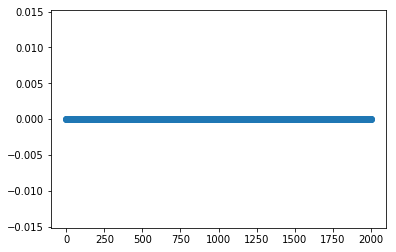

In [12]:
# plt.plot(pi.data.numpy())
plt.scatter([i for i in range(len(max_cal))], max_cal)

Stochastic Model
================

In [8]:
for i in range(4000):
    pi, mu, std = mdn(inputs)
    results = (nextstates.unsqueeze(1).expand_as(mu) - mu).pow(2)
    results = results * torch.reciprocal(std)
    results = torch.exp(-0.5 * results) * torch.reciprocal(std)
    results = torch.prod(results, axis=2)
    
    results = -torch.log(torch.sum(results*pi,1) + 1e-5)
    loss = results.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(i, loss.item())



0 1.6615070104599
100 0.784794807434082
200 0.4779616594314575
300 0.33713796734809875
400 0.24787238240242004
500 0.18302327394485474
600 0.13693182170391083
700 0.10436352342367172
800 0.07918629050254822
900 0.05965116620063782
1000 0.0440392829477787
1100 0.03128611668944359
1200 0.023923367261886597
1300 0.01977727562189102
1400 0.017315944656729698
1500 0.015712518244981766


KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt


In [10]:
true_path     = []
true_ns       = []
actions_taken = []
state = env.reset()
for t in range(1000):
    true_path.append(state)
    action = env.action_space.sample()
    actions_taken.append(action.copy())
    nextstate, rew, done, _ = env.step(action)
    if done:
        state = env.reset()
    true_ns.append(nextstate.copy())
    state = nextstate.copy()
#     env.render()


In [11]:
true_path = np.stack(true_path)
actions_taken = np.stack(actions_taken)
inputs = np.concatenate([true_path, actions_taken], axis=1)
true_ns = np.stack(true_ns)

In [12]:
from mdn_model import gumbel_sample

In [13]:
pi = mdn.pi(torch.FloatTensor(inputs))

In [14]:
gumbel_sample(nn.functional.softmax(pi, -1).data.numpy()+1e-5)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [15]:
pred = mdn(torch.FloatTensor(inputs), predict=True)
pred = pred.data.numpy()

/home/anon/sand_box/research-projects/SMPO/mdn_model.py:10: RuntimeWarning: divide by zero encountered in log
  return (np.log(x) + z).argmax(axis=axis)


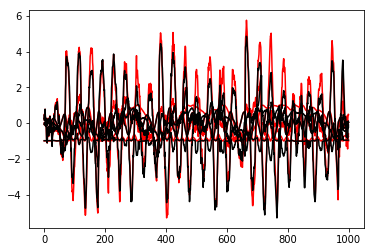

In [17]:
plt.plot(true_ns,'r')
plt.plot(pred, 'k')
plt.show()

In [32]:
pred[21,:]

array([-0.9147066 , -0.35538417, -1.4366535 ], dtype=float32)

In [33]:
pred[20,:]

array([-0.89243543, -0.4139206 , -1.0535191 ], dtype=float32)

In [34]:
pred[22,:]

array([-0.9407345 , -0.28462148, -1.4138105 ], dtype=float32)

In [20]:
# for i in range(6):
#     print(mdn.mu.weight[i*2:i*2+2, :])

mdn.mu.weight

Parameter containing:
tensor([[-0.2645, -0.1515, -0.1107],
        [ 0.2676,  0.3399,  0.3577],
        [-0.0215, -0.1986,  0.3614],
        [-0.3179,  0.5761,  0.5308],
        [ 0.3489, -0.3856,  0.3801],
        [-0.4198, -0.3333,  0.0794],
        [-0.0283,  0.3000, -0.2246],
        [ 0.1291, -0.3524,  0.2487],
        [-0.1281,  0.1273, -0.1887],
        [-0.4122,  0.1358, -0.5213]], requires_grad=True)

In [17]:

oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
#     result = torch.sum(-0.5 * (result * result), 2)
    result = -0.5 * (result * result)
    result = (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI
    return torch.prod(result, 2)
    
    
def mdn_loss_fn(pi, sigma, mu, y, eps=1e-3):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result + eps)
    return torch.mean(result)


In [7]:
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks

class MDN(nn.Module):
    def __init__(self, num_features, num_inputs, num_outputs):
        super(MDN, self).__init__()
        self.num_features = num_features
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs        
        n_hidden = 20
        self.z = nn.Sequential(
            nn.Linear(num_inputs, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU()
        )
        
        self.pi = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, num_features)        
        )
        self.log_stddev = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, num_features*num_outputs)
        )
        self.mu = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, num_features*num_outputs)
        )

    def forward(self, x):
        z = self.z(x)
        pi = nn.functional.softmax(self.pi(z), -1)
        mu = self.mu(z)
        mu = mu.view(-1,self.num_features,self.num_outputs)
        sigma = torch.exp(self.log_stddev(z))
        sigma = sigma.view(-1, self.num_features, self.num_outputs)
        return pi, sigma, mu


In [8]:
mdn = MDN(2, 3, 2)
optimizer = Adam(mdn.parameters())

In [11]:
for it in range(1000):
    pi, sigma, mu = mdn(torch.cat([states, actions], axis=1))
    
    loss = mdn_loss_fn(pi, sigma, mu, nextstates.unsqueeze(1), eps=1e-3)
    
    optimizer.zero_grad() # prepare the optimizer
    loss.backward() # compute the contribution of each parameter to the loss
    optimizer.step() # modify the parameters
    
    if it % 100 == 0:
        print(loss.item())

1.0420321226119995
-4.75194787979126
-6.207372665405273
1.2795978784561157
-4.966353416442871


KeyboardInterrupt: 

In [113]:
torch.cat([states, actions], axis=1).shape

torch.Size([4000, 3])

In [14]:
tm = torch.cat([
    torch.ones(4,4)*i for i in range(5)
], axis=0)

In [19]:
for i in range(5):
    print(tm[i*4:i*4+4, :])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[4., 4., 4., 4.],
        [4., 4., 4., 4.],
        [4., 4., 4., 4.],
        [4., 4., 4., 4.]])
